### Importação

In [1]:
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets , metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
import random
import matplotlib.cm as cm
import numpy as np

In [2]:
random.seed(2021)

### Carregue o dataset

Iremos usar o conjunto de dados "Optical Recognition of Handwritten Digits", nele foram usados programas de pré-processamento disponibilizados pelo NIST para extrair bitmaps normalizados de dígitos manuscritos de um formulário pré-impresso. De um total de 43 pessoas, 30 contribuíram para o conjunto de treinamento e 13 diferentes para o conjunto de teste. Os bitmaps de 32x32 são divididos em blocos não sobrepostos de 4x4 e o número de pixels é contado em cada bloco. Isso gera uma matriz de entrada de 8x8, onde cada elemento é um número inteiro no intervalo de 0 a 16. Isso reduz a dimensionalidade e dá invariância a pequenas distorções.

In [3]:
digits = datasets.load_digits()

### Para visualizar os dígitos execute a célula abaixo

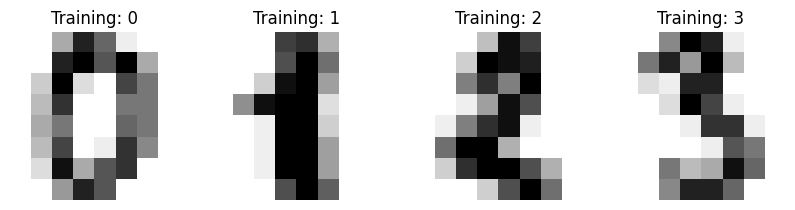

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

### Para usar a imagem, precisamos formatar cada matriz de pixels como um array de uma única  linha, a célula abaixo executa este processo

In [4]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

### Imprima o número de linhas e de colunas do conjunto de dados

In [5]:
data.shape

(1797, 64)

### Para avaliação da clusterização vamos utilizar duas métricas: a Inércia e a Silhoueta

A métrica inércia é a soma das distâncias ao quadrado das amostras até o centro do cluster mais próximo, ponderadas pelos pesos das amostras, quando fornecidas.

Na análise de cluster, o método do cotovelo é uma heurística usada para determinar o número de clusters em um conjunto de dados. O método consiste em plotar a variação explicada em função do número de clusters e escolher o cotovelo da curva como o número de clusters a usar.

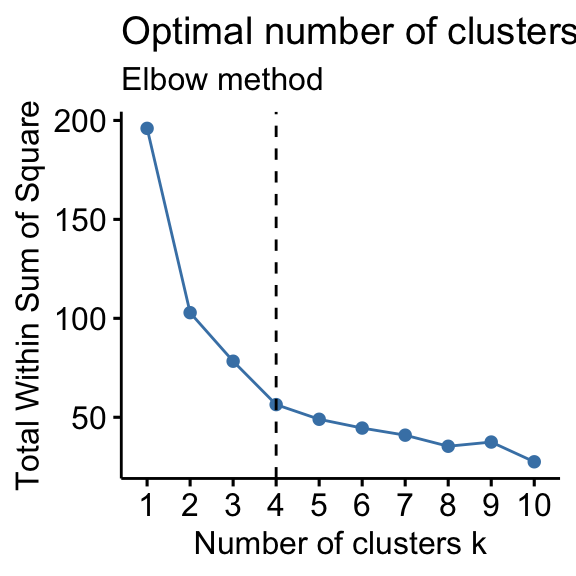

### Silhoueta

O Coeficiente de Silhueta é calculado usando a distância média intra-cluster (a) e a distância média do cluster mais próximo (b) para cada amostra. O coeficiente de silhueta para uma amostra é (b - a) / max(a, b). Para esclarecer, b é a distância entre uma amostra e o cluster mais próximo do qual a amostra não faz parte. Observe que o Silhouette Coeficiente só é definido se o número de rótulos for 2 <= n_labels <= n_samples - 1.

O melhor valor é 1 e o pior valor é -1. Valores próximos a 0 indicam clusters sobrepostos. Valores negativos geralmente indicam que uma amostra foi atribuída ao cluster errado, pois um cluster diferente é mais semelhante.

A análise de silhueta pode ser usada para estudar a distância de separação entre os clusters resultantes. O gráfico de silhueta exibe uma medida de quão próximo cada ponto em um cluster está dos pontos nos clusters vizinhos e, portanto, fornece uma maneira de avaliar parâmetros como o número de clusters visualmente. Esta medida tem um intervalo de [-1, 1].

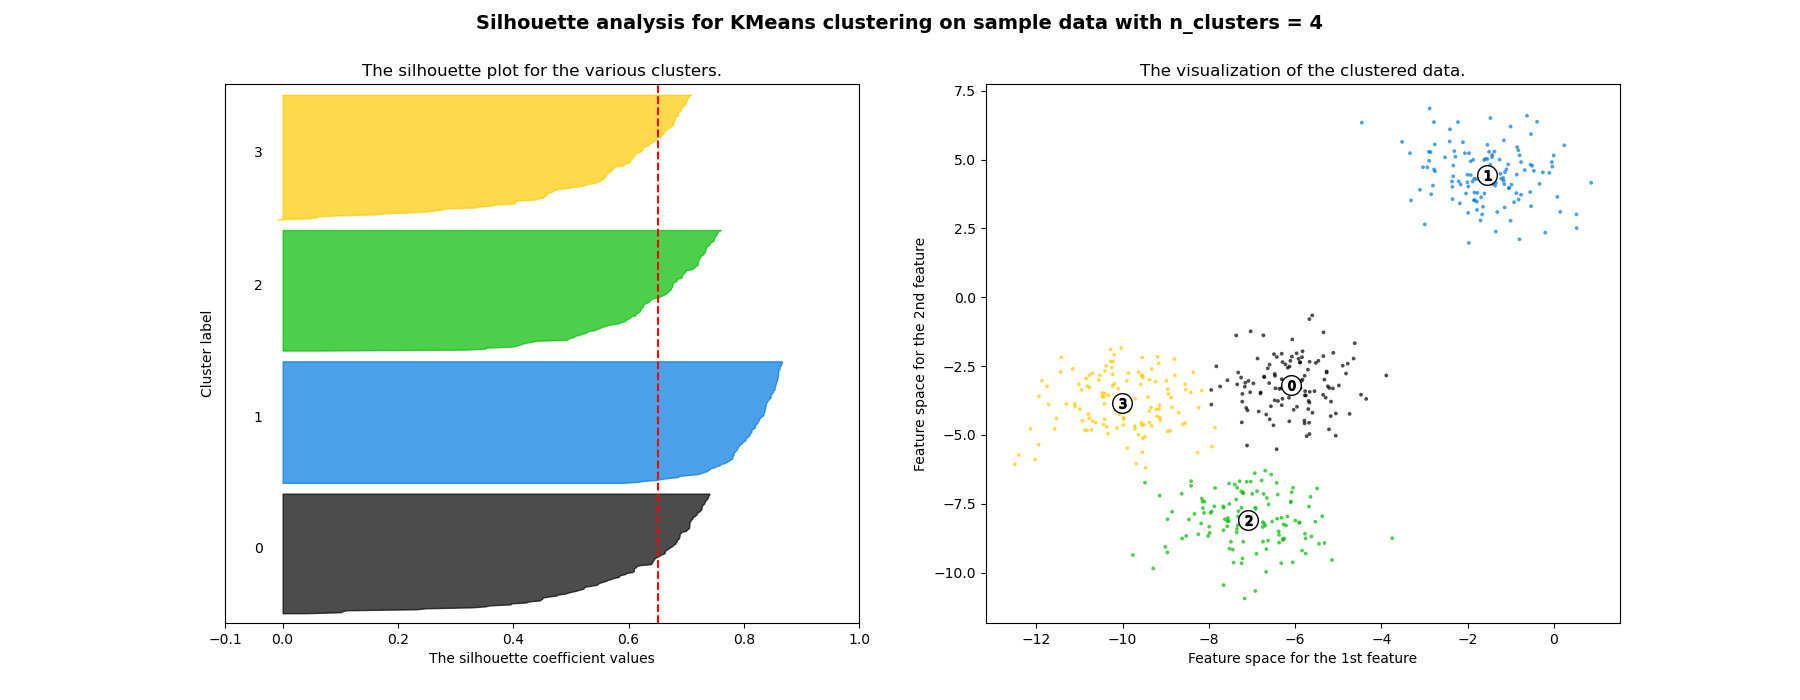

### Usando o K-means

In [6]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X=data)


C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [7]:
#obtendo a inercia e o score de silhoueta
sl_avg = metrics.silhouette_score(data, kmeans.labels_, metric="euclidean")
print(sl_avg)
print(kmeans.inertia_)

0.12649498093440542
1730182.260086908


### A função a seguir plot o gráfico da silhueta

In [5]:
def plot_silhouette(cl, sample_sv , silhouette_avg, k ):
    X = data
    y_lower = 10

    n_clusters = cl.n_clusters
    cluster_labels = cl.labels_
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_sv[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the {} clusters".format(k))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])



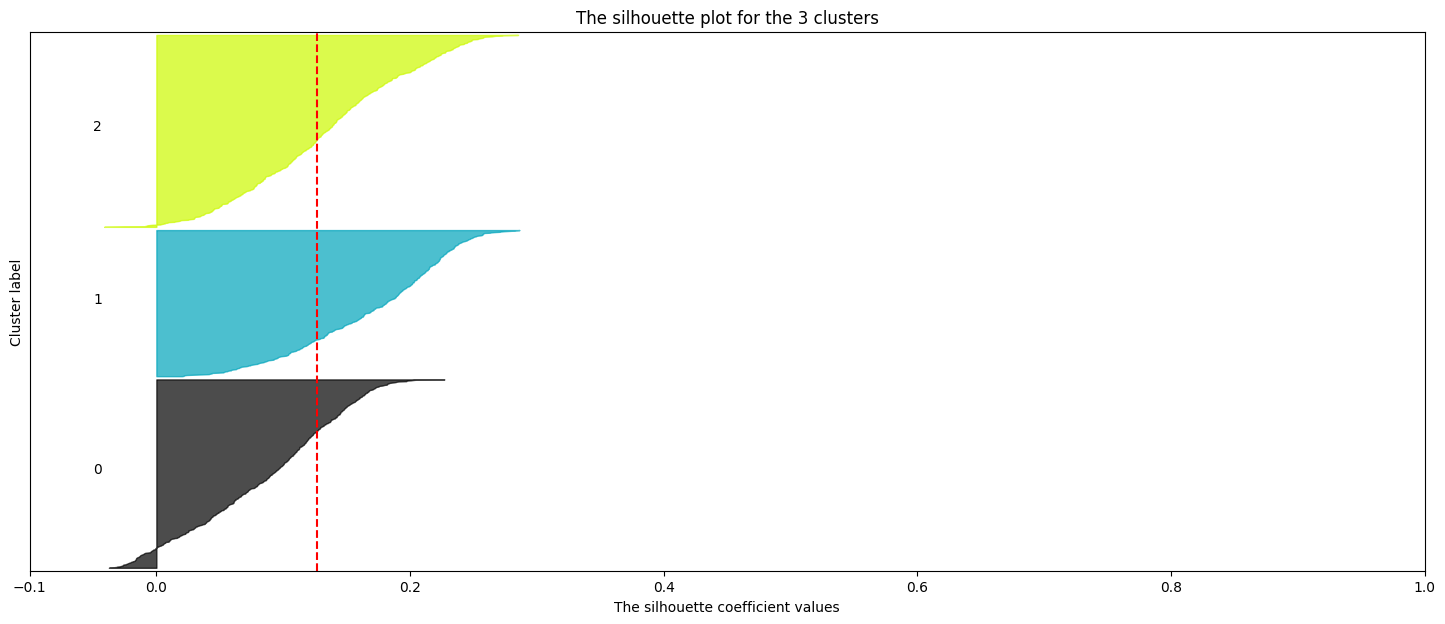

In [ ]:
plot_silhouette(kmeans, silhouette_samples(data, kmeans.labels_) , sl_avg, 3 )

### Agora vamos variar o valor de k e escolher de acordo com o gráfico do método do cotovelo. Também coletar os valores de silhueta para cada clusterização


In [73]:
clusterings = []
inertias =[]
silhouettes = []
sample_silhouette_values = []
mink= 2
maxk= 15
for k in range(mink, maxk):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X=data)
    clusterings.append(kmeans)
    inertias.append(kmeans.inertia_)
    silhouettes.append(metrics.silhouette_score(data, kmeans.labels_, metric="cosine"))
    sample_silhouette_values.append(silhouette_samples(data, kmeans.labels_))


C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\franc\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

### Plot o gráfico com a variação da inércia obtida e escolha o melhor valor de k pelo método do cotovelo

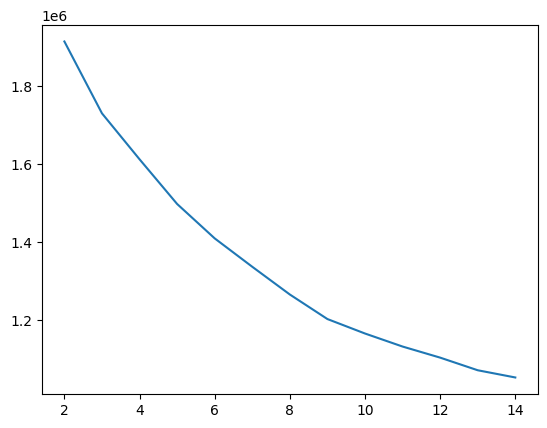

In [74]:
plt.plot(range(mink, maxk), inertias)

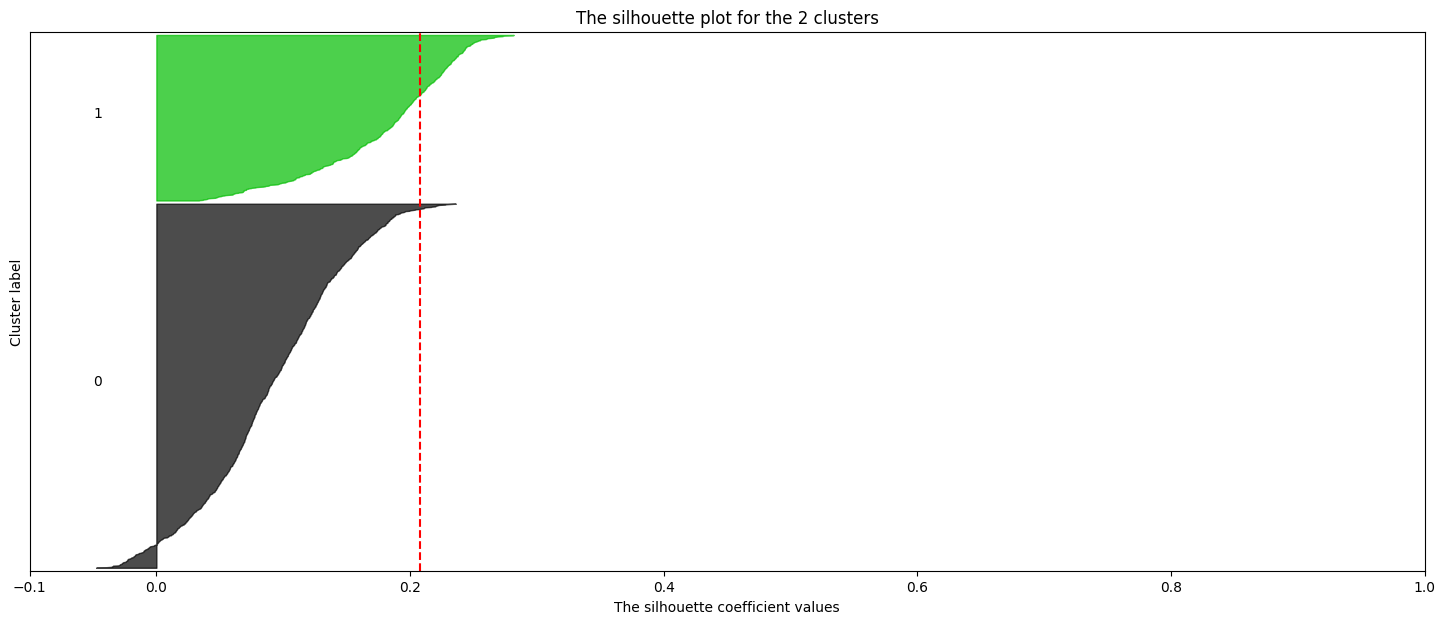

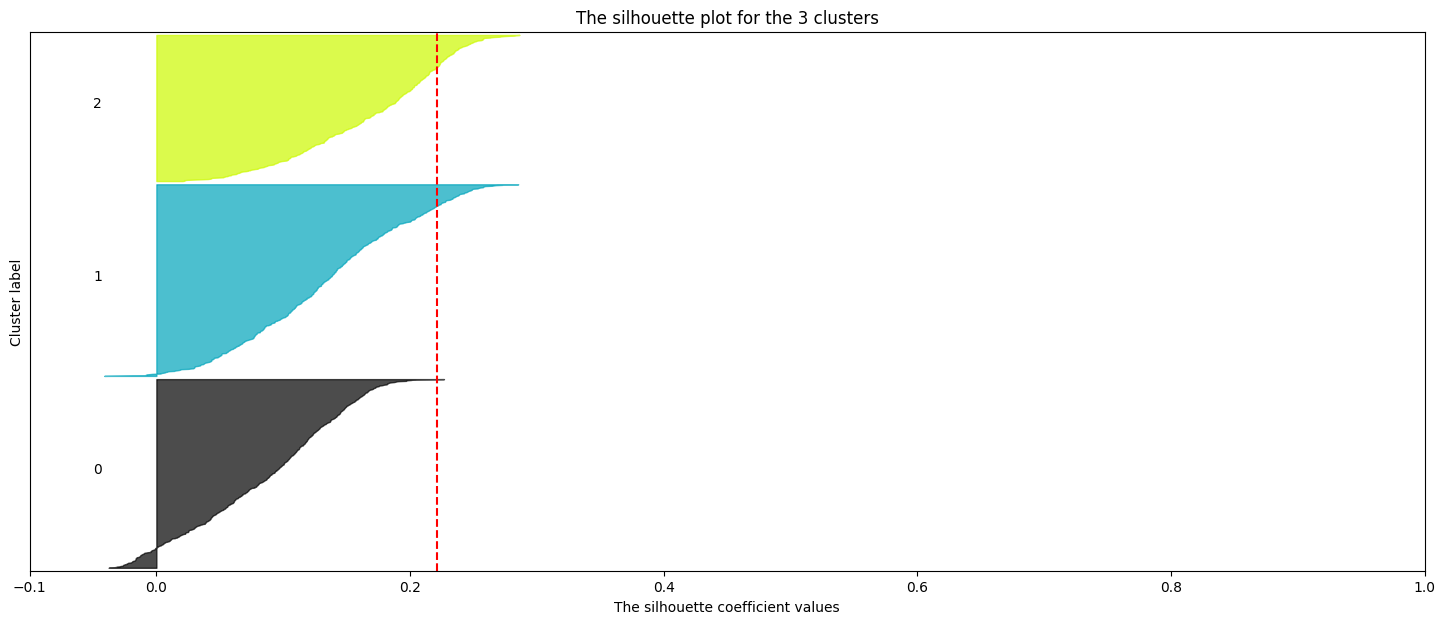

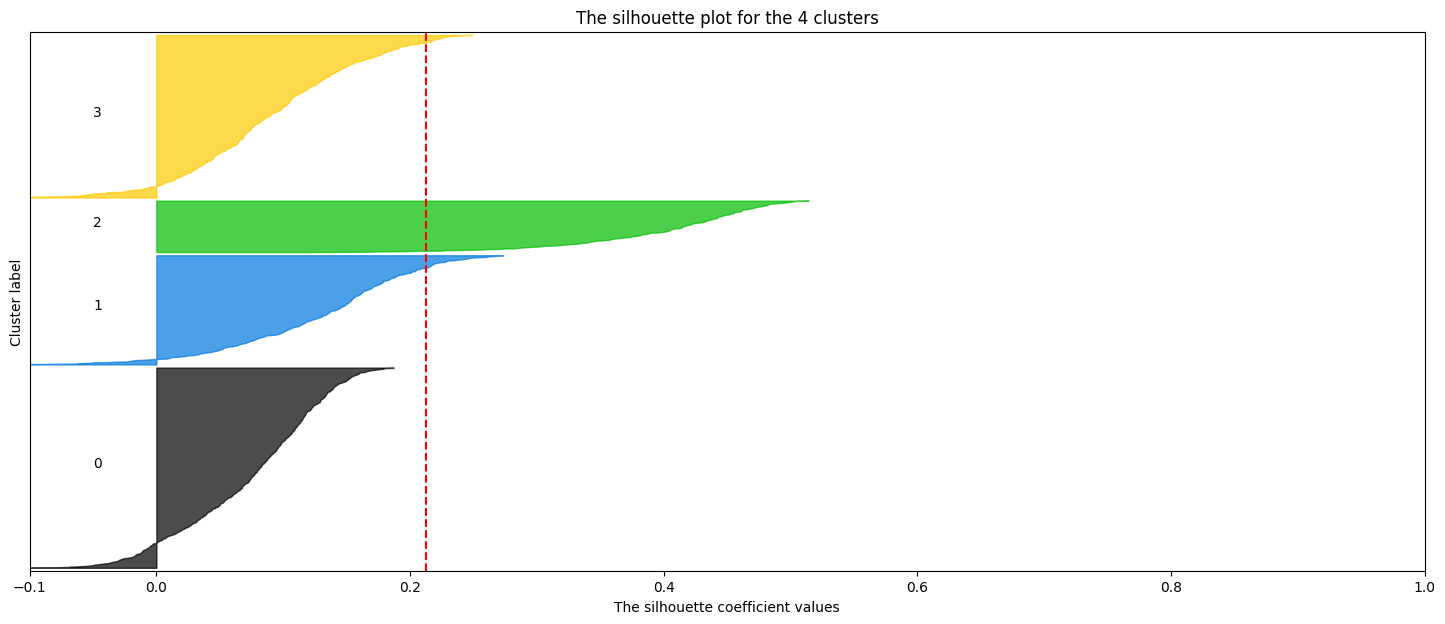

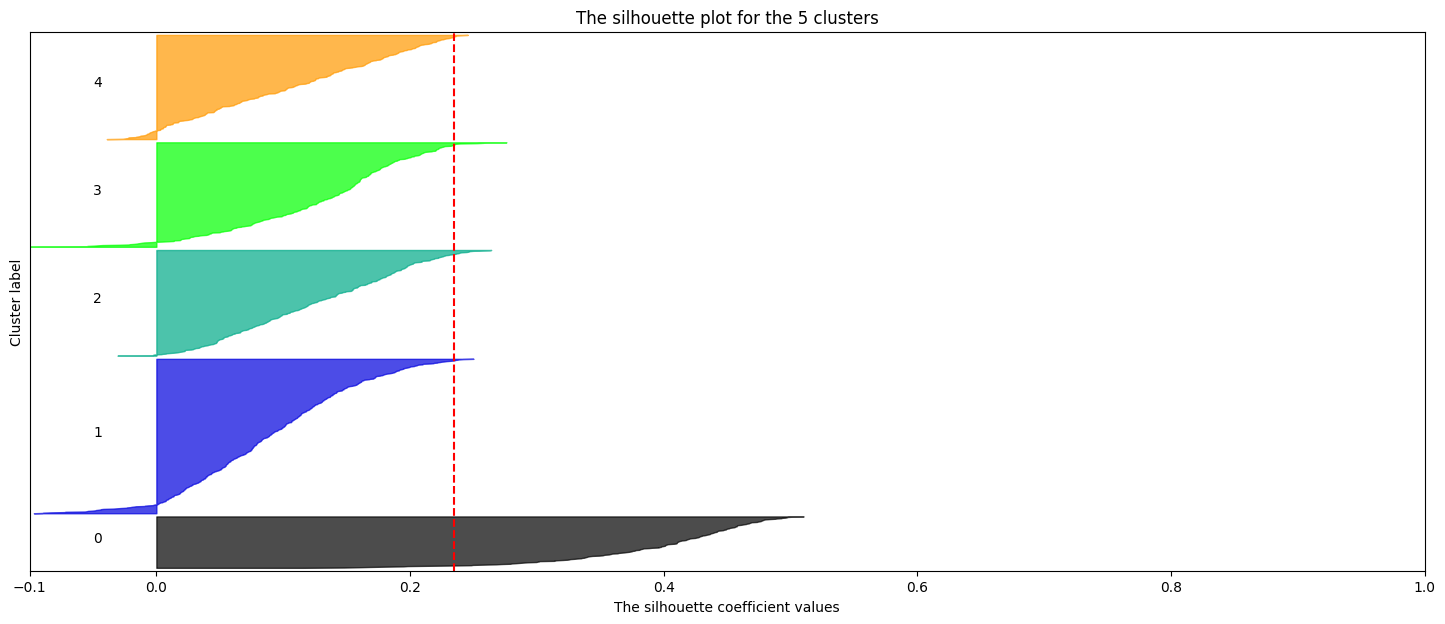

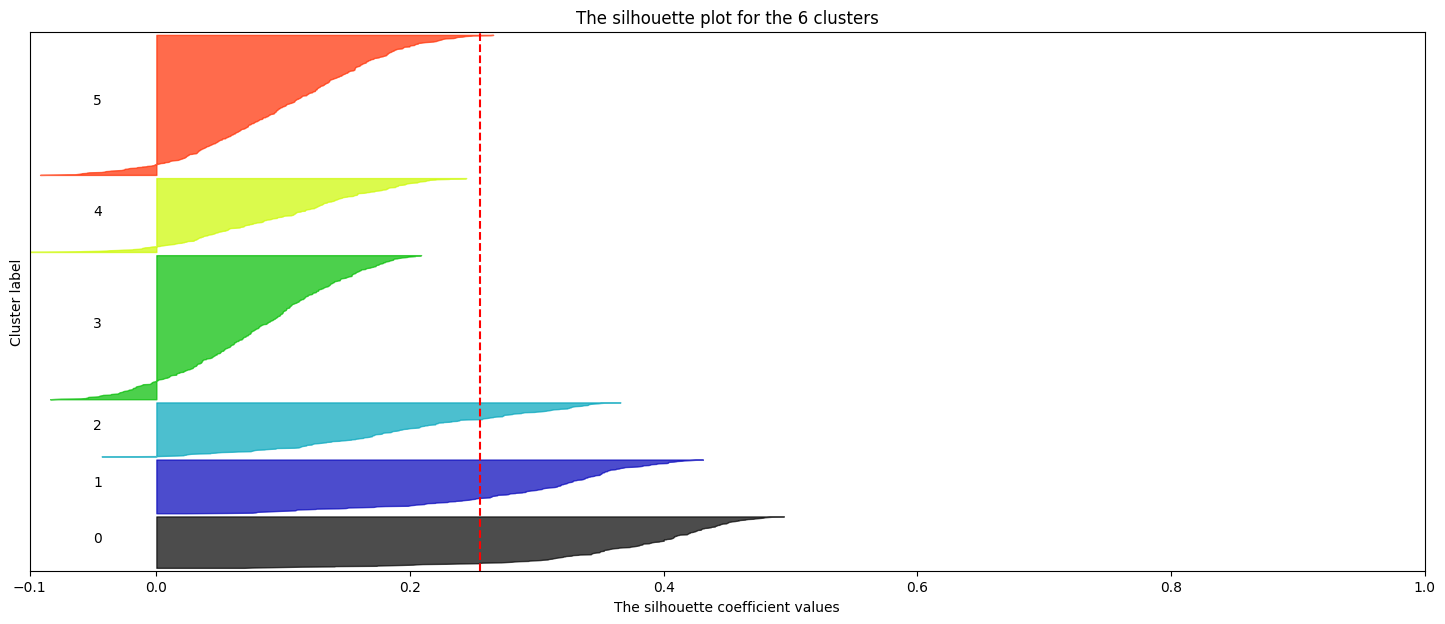

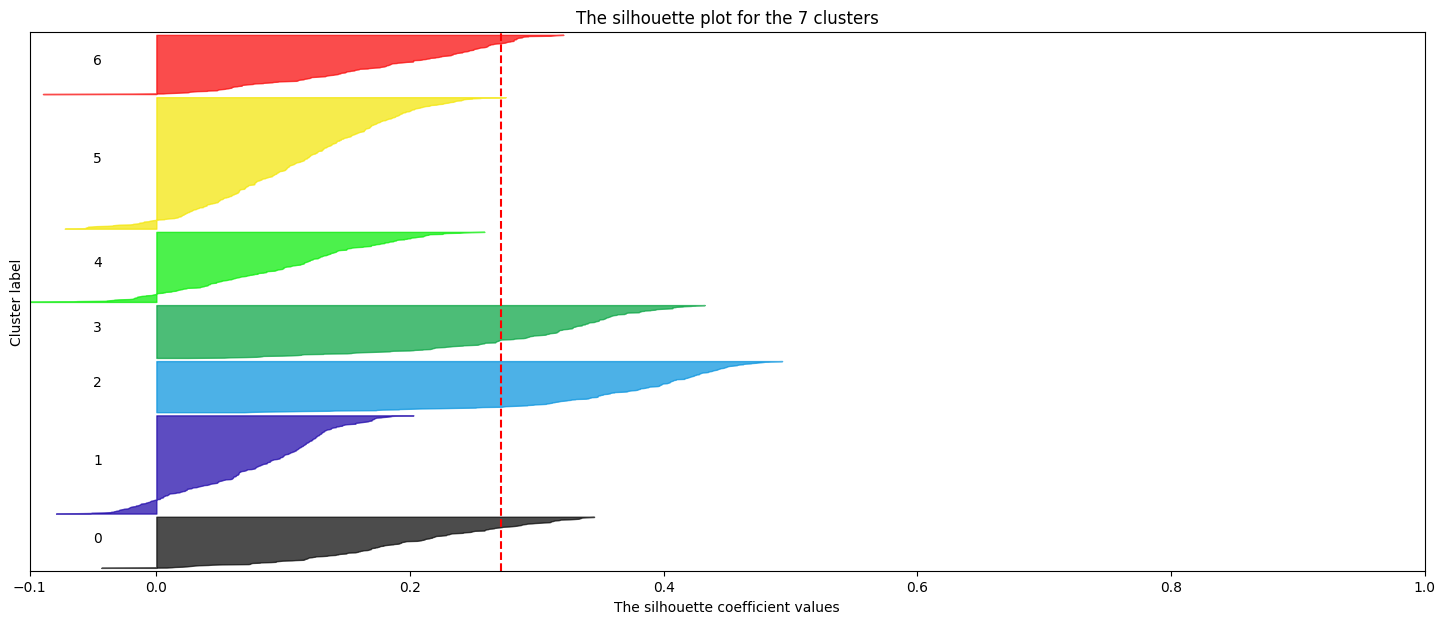

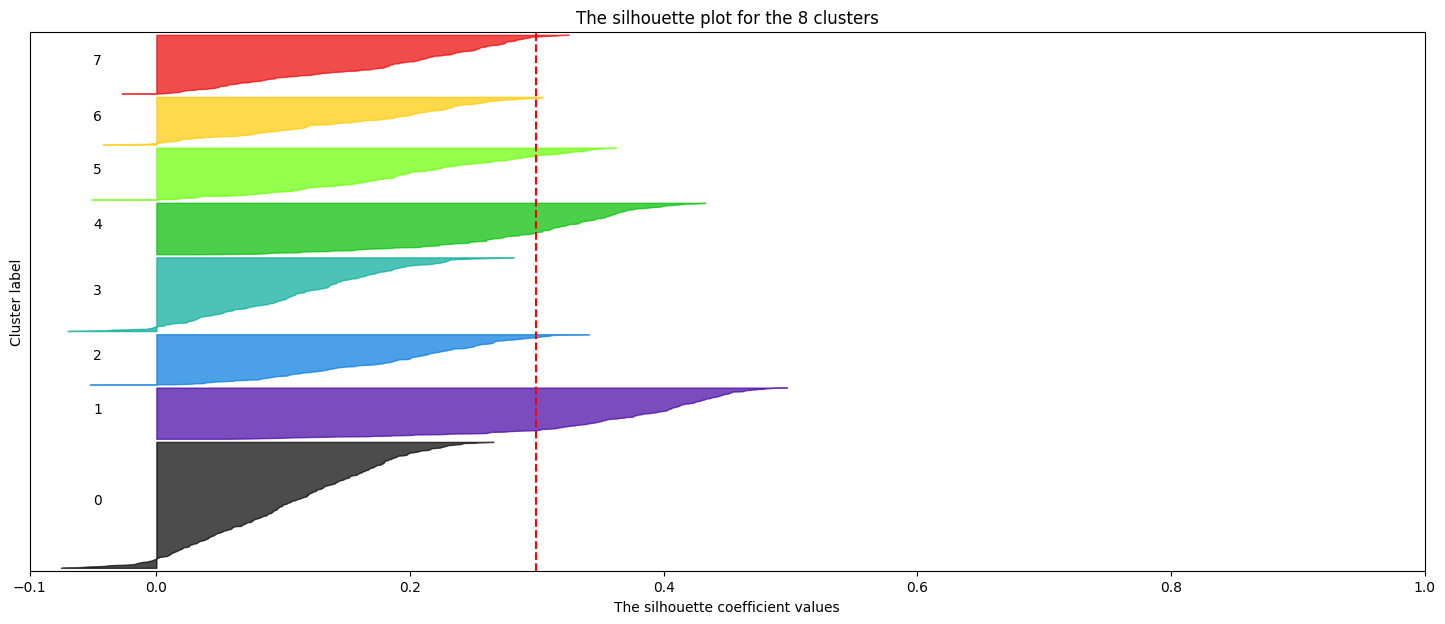

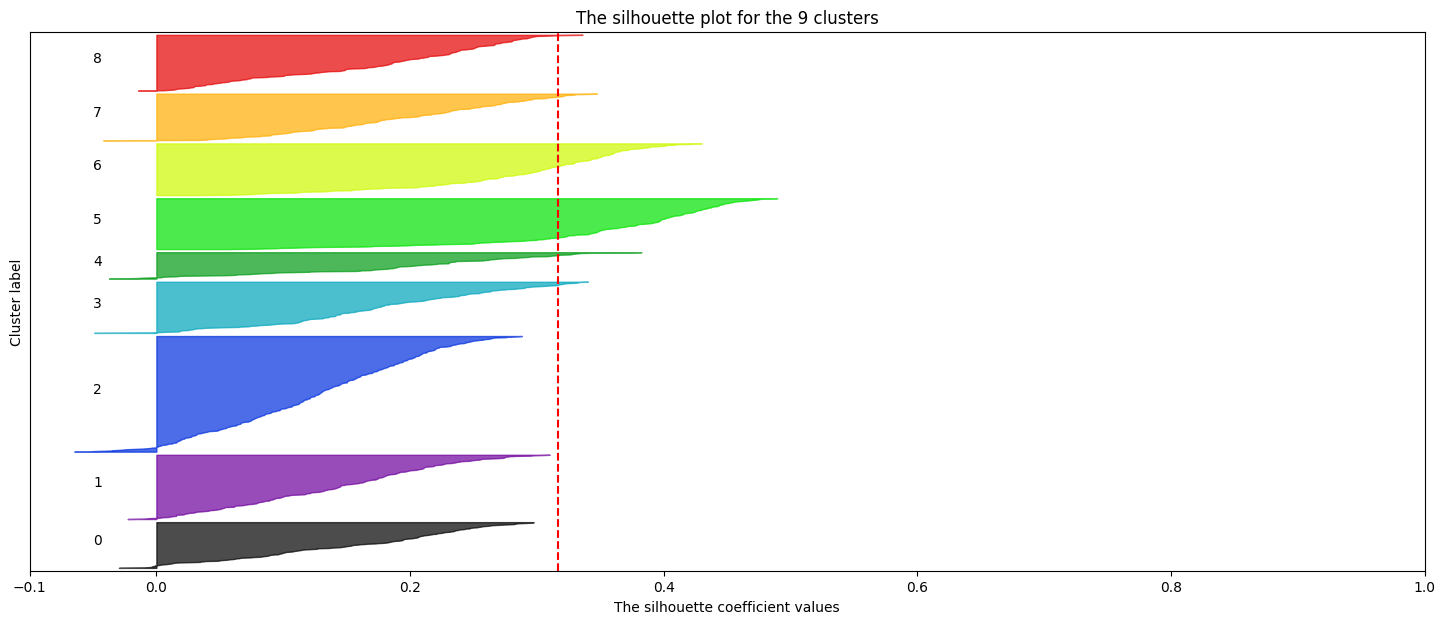

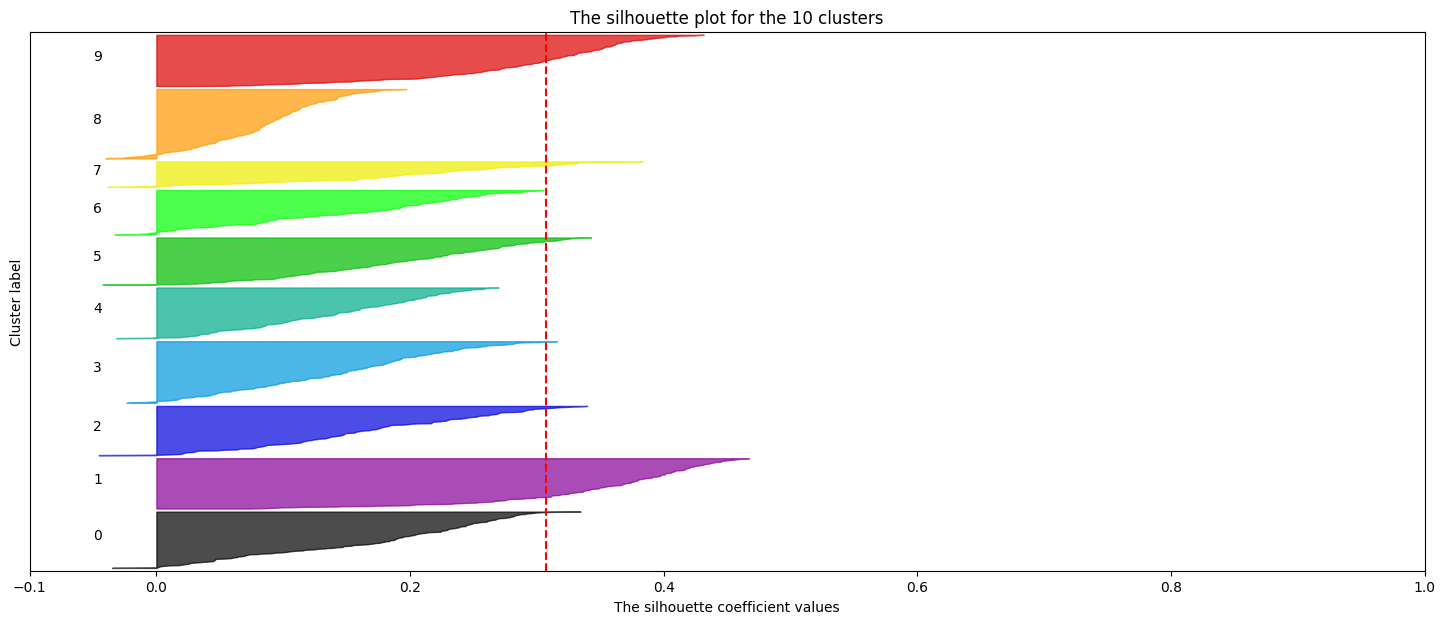

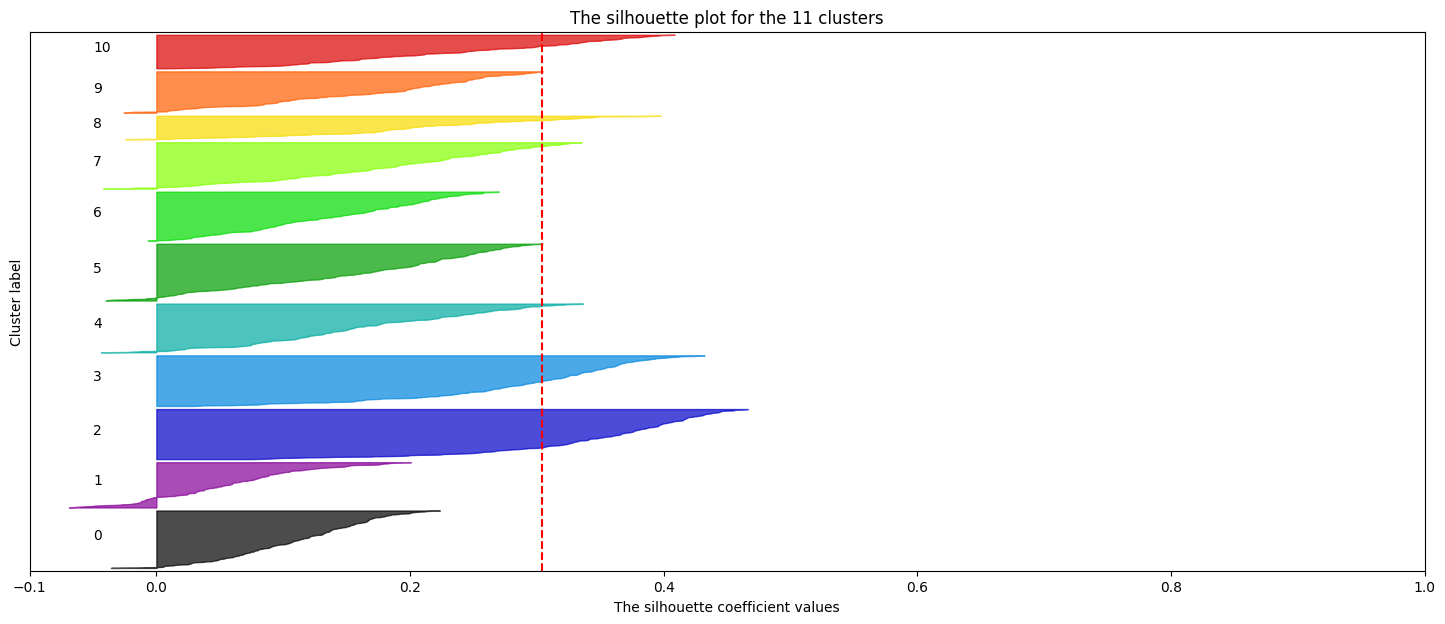

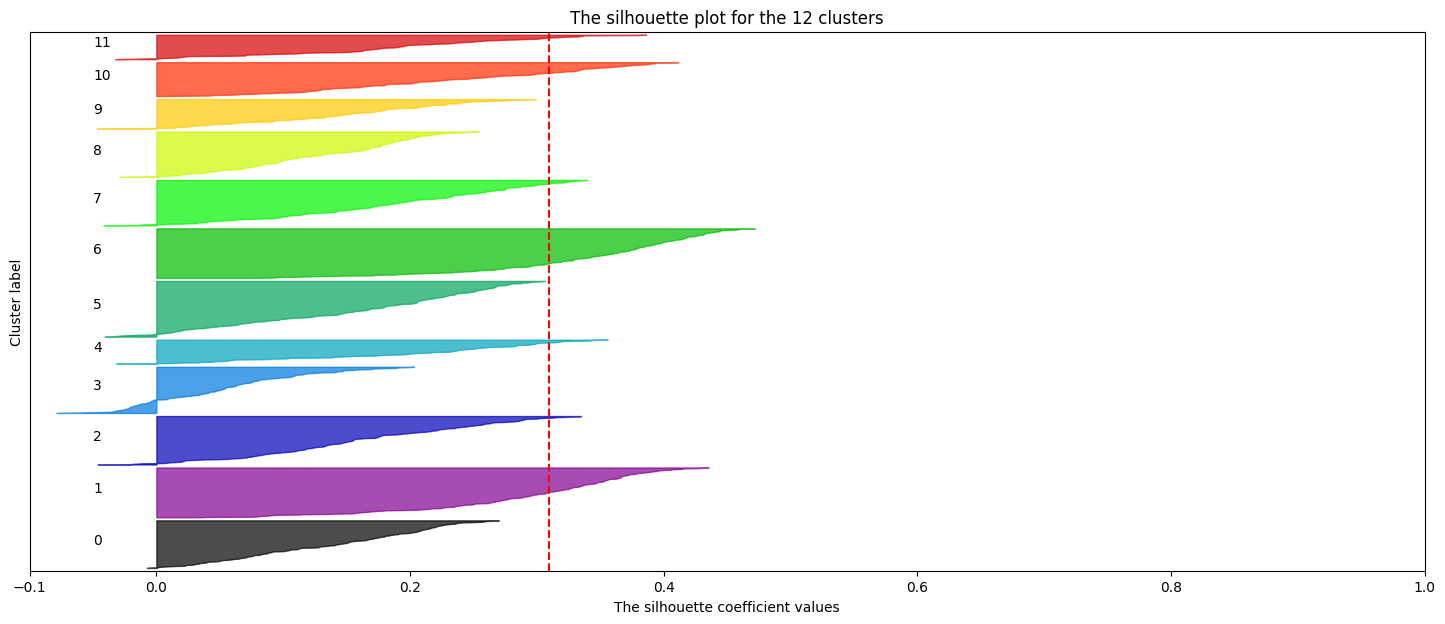

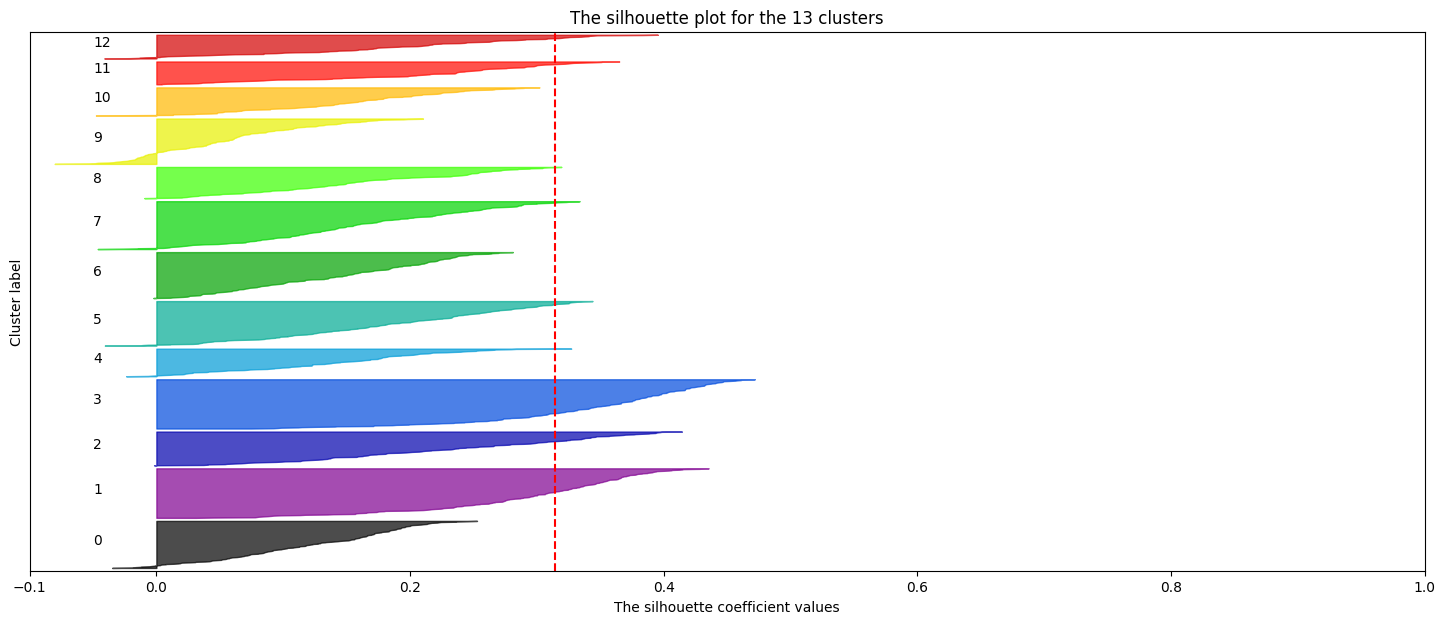

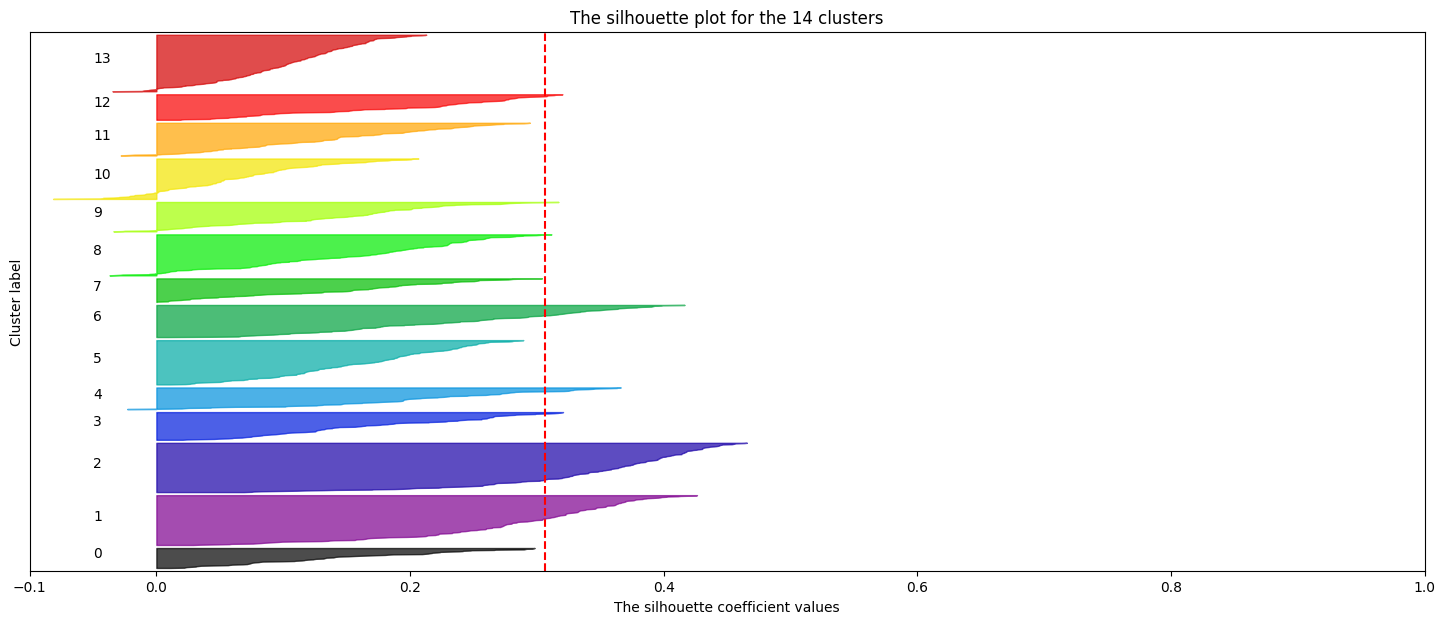

In [75]:
for cl, sample_sv , silhouette_avg in zip(clusterings, sample_silhouette_values, silhouettes):
    plot_silhouette(cl, sample_sv, silhouette_avg, cl.n_clusters)

### Vamos plotar  imagens de alguns clusters. Observe se há valores atribuídos erroneamente.

In [89]:
bestKValue = 9
result = clusterings[bestKValue - 2]
# Atenção: substitua a variável result pela melhor clusterização encontrada

In [90]:

result.labels_

array([5, 1, 1, ..., 1, 2, 2])

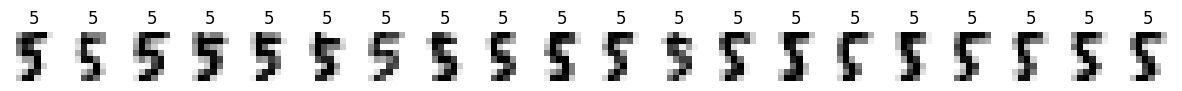

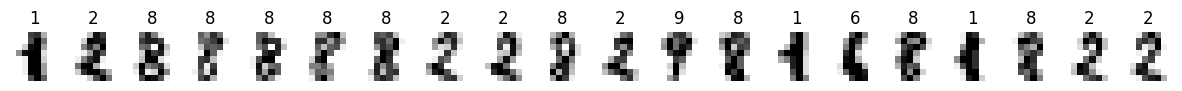

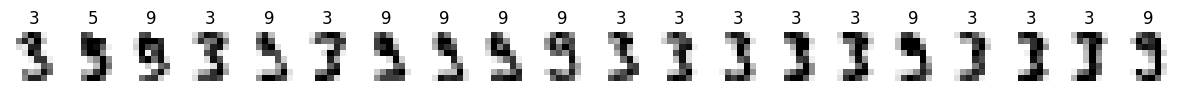

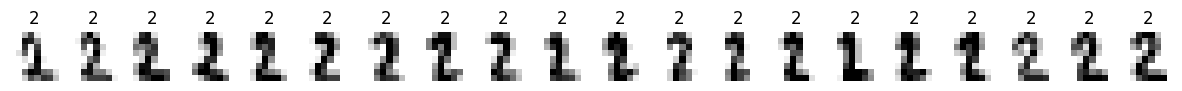

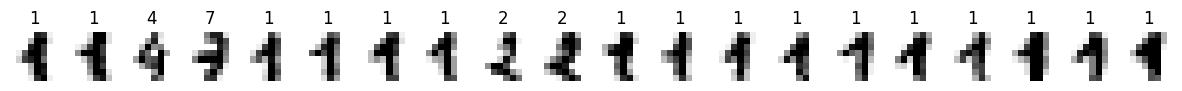

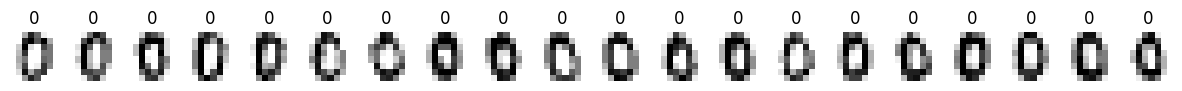

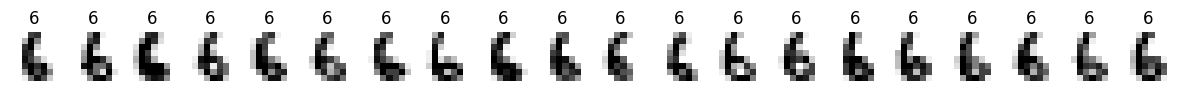

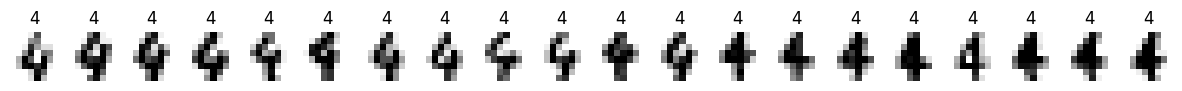

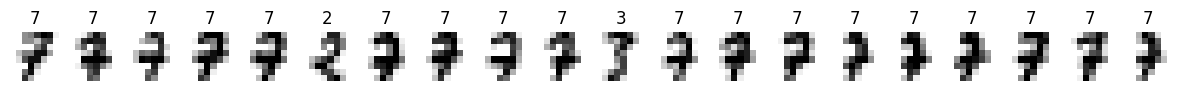

In [91]:
for i in range(0, bestKValue):
    _, axes = plt.subplots(nrows=1, ncols=20, figsize=(15,15))
    for ax, image, label in zip(axes, digits.images[result.labels_==i], digits.target[result.labels_==i]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('%i' % label)

## Para usar a clusterização e predizer o cluster de uma nova instância, usamos o método predict

#### Note que no exemplo foi utilizada uma instância usada na clusterização, apenas para exemplificar a utilização do método

In [71]:
# Predict the value of the digit on the test subset
predicted = result.predict([data[100,:]])

In [72]:
predicted

array([8])